# Documentation
<br>
This notebook is the first step in a workflow that deals with Bradford Protein Quantification 96x well plate reader data:

1. Exploratory data analysis.
2. Cleaning the data to remove absorbance values that are outside the linear range of the instrument
3. Parsing and exporting both the calibrant and sample data into the processed_data_files directory preparatory to downstream analysis

Alex Perkins 16th November 2021
a.j.p.perkins@sms.ed.ac.uk

### Environment Preparation ---------------------------------------------------------------

### Import Packages

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")

import arviz as az
from scipy.stats import norm

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


### This cell just deals with reading the data file in the directory

In [2]:
##################################################################

move_file = False

##################################################################
# define error handler
class UnAcceptedValueError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

####################################################################
# gets all items in directory
items = os.listdir(".")

# lists all .csv
csv_list = []
for names in items:
    if names.endswith(".CSV"):
        csv_list.append(names)
print(csv_list)
try:
    if(len(csv_list) > 1):
        raise UnAcceptedValueError("More than 1x .CSV file in the directory");
except UnAcceptedValueError as e:
    print ("Received error:", e.data)
    # kills the process
    quit()
##########################################################################################
#import dataset as dataframe
raw_data = pd.read_csv(csv_list[0], header=None)

date= raw_data.iloc[1,1]

data = raw_data.iloc[6:,:]
data = data.reset_index(drop=True)


calibrants = data.iloc[48:72,[2]]

#######################################################################

print(os.getcwd())
path = "/src/output/"
# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
# now that the dataset has been read in, move it into the output file for neatness.
if 1 == move_file:
    shutil.move(csv_list[0], path)

# navigate into the directory for future plot storage
os.chdir(path)

['2021_12_08_standard_curve_opp1_first_run_raw.CSV']
/src


### End of Enviroment Setup ---------------------------------------------------------------------------

In [3]:
#  define limits for linear range of platereader
upper_limit = 0.75
lower_limit = 0.45


# Looking at the raw calibrant data

## Step 1: Looking at the raw values

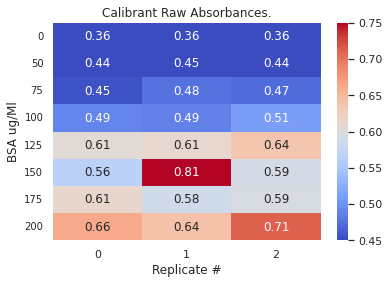

In [4]:
# reshape
calibrants = calibrants.astype(float)
calibrants_np = calibrants.to_numpy()

replicates = 3

# real concs in wells. Stocks in ug/ml diluted by 20x
calibrant_range = ["0","50","75","100", "125", "150", "175","200"]

calibrants_np_2d = np.reshape(calibrants_np, (int(len(calibrants_np)/replicates), replicates))

import seaborn as sns

sns.set()
ax1 = sns.heatmap(calibrants_np_2d, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")
ax1.set_ylabel("BSA ug/Ml")
ax1.set_title("Calibrant Raw Absorbances.")
ax1.set_xlabel("Replicate #")
plt.yticks(np.arange(8)+0.5,calibrant_range, rotation=0, fontsize="10")

plt.savefig("BSA_absorbances_heat.png")

plt.show()

## Step 2: Reorganising Calibrant Data

In [5]:
# segregate the calibrant samples.
calibrants_df = pd.DataFrame(calibrants_np_2d, columns=["Rep1", "Rep2", "Rep3"], index=calibrant_range)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


    Concentration  Absorbance
0             0.0       0.360
1             0.0       0.361
2             0.0       0.362
3            50.0       0.442
4            50.0       0.445
5            50.0       0.441
6            75.0       0.454
7            75.0       0.476
8            75.0       0.472
9           100.0       0.490
10          100.0       0.488
11          100.0       0.509
12          125.0       0.607
13          125.0       0.612
14          125.0       0.636
15          150.0       0.565
16          150.0       0.806
17          150.0       0.590
18          175.0       0.613
19          175.0       0.585
20          175.0       0.594
21          200.0       0.663
22          200.0       0.640
23          200.0       0.712


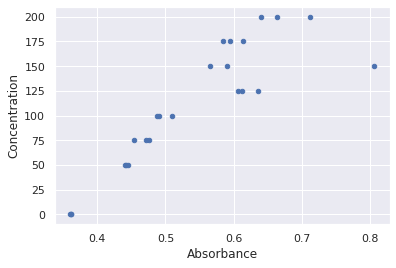

In [6]:
# define the function to use it later
def reorg_calibrants_for_GLM(input_data):
    output_for_glm = pd.DataFrame(columns=['Concentration', 'Absorbance'])
    for idx, row in input_data.iterrows():


        r_list = [row['Rep1'],row['Rep2'],row['Rep3']]

        place_holder_df = pd.DataFrame()

        place_holder_df['Absorbance'] = r_list
        place_holder_df['Concentration'] = np.float(idx)

        output_for_glm = output_for_glm.append(place_holder_df)

    output_for_glm =output_for_glm.reset_index(drop=True)
    print(output_for_glm)

    output_for_glm.plot.scatter(x='Absorbance', y='Concentration')
    
    return output_for_glm

calibrants_for_GP = reorg_calibrants_for_GLM(calibrants_df)

## Step 3: Filter the calibrants and only keep those within the linear range  (0.75 - 0.45)

In [7]:
##################   Subset Standards aborbance values that fall within the linear range (0.75 - 0.45)

calibrants_for_GP = calibrants_for_GP.loc[(calibrants_for_GP["Absorbance"] >= lower_limit) & (calibrants_for_GP["Absorbance"] <= upper_limit)]
calibrants_for_GP = calibrants_for_GP.reset_index(drop=True)
print(calibrants_for_GP)

    Concentration  Absorbance
0            75.0       0.454
1            75.0       0.476
2            75.0       0.472
3           100.0       0.490
4           100.0       0.488
5           100.0       0.509
6           125.0       0.607
7           125.0       0.612
8           125.0       0.636
9           150.0       0.565
10          150.0       0.590
11          175.0       0.613
12          175.0       0.585
13          175.0       0.594
14          200.0       0.663
15          200.0       0.640
16          200.0       0.712


## Step: 4 Defining the absorbance of each concentration as a gaussian.

This allows us to store the mean concentration and it's error as a function and calculate the probabilities on demand.

Lets assume that the technical error of the absorbance measurements are normally distributed

1. We calculate the mean and the standard deviation for each absorbance triplicate.
2. We define a gaussian sampling function so we can easily sample and return a granular array.

In [8]:


# calculate the mean of each triplicate
calibrants_df["Mean"] = calibrants_df.mean(axis=1)
# calculate the variance of each triplicate
calibrants_df["σ"] = calibrants_df.iloc[:,:3].std(axis=1)

calibrants_df_avg = calibrants_df[["Mean", "σ"]]


def sample_gaussian(mu, sigma):
    
    # define the x range: mean - 4*sigma and mean + 4*sigma. increments = mean/1000
    x = np.arange((mu-(4*sigma)),(mu+(4*sigma)), mu/1000)
    
    # use the norm.pdf (probability density function) to sample and return the array.
    return norm.pdf(x, mu, sigma)

# do it for each calibrant. Not currently stored.
for idx, row in calibrants_df_avg.iterrows():
    sample_gaussian(calibrants_df.loc[idx]["Mean"], calibrants_df.loc[idx]["σ"])


Having got our function, lets plot all the gaussians together and have a wee look.

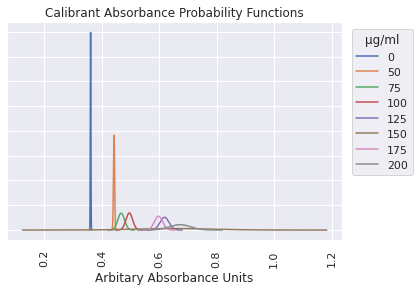

In [9]:
def print_all_gaussians(mu, sigma, bins, index):
    
    # define the x range: mean - 4*sigma and mean + 4*sigma. increments = mean/1000
    x = np.arange((mu-(4*sigma)),(mu+(4*sigma)), mu/1000)
    
    # plot the function
    plt.plot(x, norm.pdf(x, mu, sigma),  label=str(idx))
    

# do it for every calibrant and produce the plot afterwards
for idx, row in calibrants_df.iterrows():
    print_all_gaussians(calibrants_df.loc[idx]["Mean"], calibrants_df.loc[idx]["σ"], 10000, idx)

# just setting the labels and ticks
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=True)

plt.title('Calibrant Absorbance Probability Functions')
plt.xticks(rotation=90)
plt.xlabel('Arbitary Absorbance Units')

plt.legend(title='μg/ml', loc=(1.03, 0.3))

plt.savefig('Calibrant Absorbance Probabilty Functions.png')

# Sample Data

# Step 1: Looking at the raw sample data

24


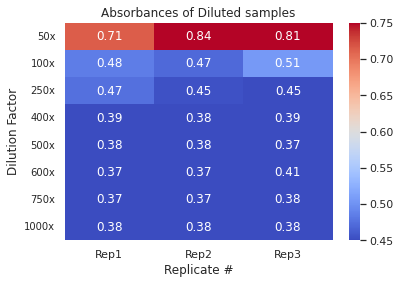

In [10]:
# samples mean & sem
sample_data = data.iloc[24:48,2].astype(float)
print(len(sample_data))

sample_data = sample_data.values
sample_data = sample_data.reshape((int(len(sample_data)/replicates), replicates))

sample_list =["50x","100x","250x", "400x", "500x","600x","750x","1000x"]

sample_data = pd.DataFrame(sample_data, columns=["Rep1", "Rep2", "Rep3"], index = sample_list)




sns.set()


sns.heatmap(sample_data, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")



plt.ylabel("Dilution Factor")
plt.title("Absorbances of Diluted samples")
plt.xlabel("Replicate #")
plt.yticks(np.arange(sample_data.shape[0])+0.5, sample_list, rotation=0, fontsize="10")
plt.savefig("Sample_Absorbances_heat.png")



## Step 2: Reorganising Sample Data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


   Dilution  Absorbance
0        50       0.714
1        50       0.838
2        50       0.810
3       100       0.484
4       100       0.471
5       100       0.506
6       250       0.475
7       250       0.454
8       250       0.451
9       400       0.391
10      400       0.379
11      400       0.386
12      500       0.379
13      500       0.377
14      500       0.373
15      600       0.373
16      600       0.373
17      600       0.406
18      750       0.372
19      750       0.371
20      750       0.383
21     1000       0.381
22     1000       0.379
23     1000       0.380


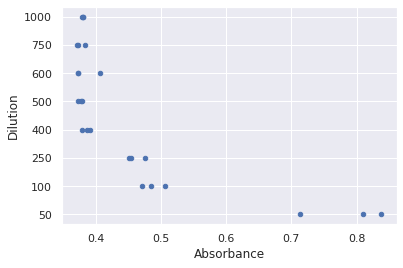

In [11]:
# define the function to use it later
def reorg_data_for_GLM(input_data):
    output_for_glm = pd.DataFrame(columns=['Dilution', 'Absorbance'])
    for idx, row in input_data.iterrows():


        r_list = [row['Rep1'],row['Rep2'],row['Rep3']]

        place_holder_df = pd.DataFrame()

        place_holder_df['Absorbance'] = r_list
        
        # chop off the 'x'
        idx_minus1 = idx[:-1]
        place_holder_df['Dilution'] = idx_minus1     

        output_for_glm = output_for_glm.append(place_holder_df)

    output_for_glm =output_for_glm.reset_index(drop=True)
    print(output_for_glm)

    output_for_glm.plot.scatter(x='Absorbance', y='Dilution')
    
    return output_for_glm

data_for_GP = reorg_data_for_GLM(sample_data)

## Step 3:  Filter the sample data and only keep those within the linear range  (0.75 - 0.45)

In [12]:
##################   Subset Standards aborbance values that fall within the linear range (0.75 - 0.45)

acceptable_data = data_for_GP.loc[(data_for_GP["Absorbance"] >= lower_limit) & (data_for_GP["Absorbance"] <= upper_limit)]
acceptable_data = acceptable_data.reset_index(drop=True)
print(acceptable_data)

  Dilution  Absorbance
0       50       0.714
1      100       0.484
2      100       0.471
3      100       0.506
4      250       0.475
5      250       0.454
6      250       0.451


# Exporting the parsed calibrant and sample data

## Step 1: Check if '/processed_data_files' exists. If not, create it and navigate inside.

In [13]:
print(os.getcwd())
path_processed_data = "/src/processed_data_files/"
# make directory for sticking the processed data in
if os.path.isdir(path_processed_data) == False:
    os.mkdir(path_processed_data, mode=0o777)

# navigate into the path_processed_data directory for data storage
os.chdir(path_processed_data)

/src/output


## Step 2: Export both calibrant and sample data into processed_data_files as CSV files.

In [14]:
calibrants_for_GP.to_csv("parsed_calibrant_data.csv")
acceptable_data.to_csv("parsed_sample_data.csv")

In [15]:
# navigate back into the root directory for neatness
os.chdir("/src/")